# Example of use of Julia with the libraries JuMP, Ipopt and Spectra: peak fitting Infrared diffusion profil
Charles Le Losq, 2016, Research School of Earth Sciences
charles.lelosq@anu.edu.au

We measured IR spectra following a 1D line along one principal axis of an olivine crystal, starting outside of the crystal and going inside toward its core. We want to determine the diffusion coefficient of hydrogen along this line. For doing so, we want to fit Gaussian peaks to the bands assigned to O-H stretching in olivine.

We face a simple model where the amplitudes of the Gaussian peaks can be determined from the equation describing the diffusion of a molecule in 1D.

Two files are taken as input: the data and a file containing the description of the data. See the comments in this file for understanding its use.
    
Typically, the user will need to modify the two lines after the call of the libraries, those lines describing where the files are.

The third line can also be modified to get the plots and select a departure point (*e.g., what spectrum really is the first one in the olivine crystal).

WARNING: A scaling coefficient of 10000 is applied to the data to bring the itnensities close to 1, in order to promote global convergence of the optimisation algorithm.

Done


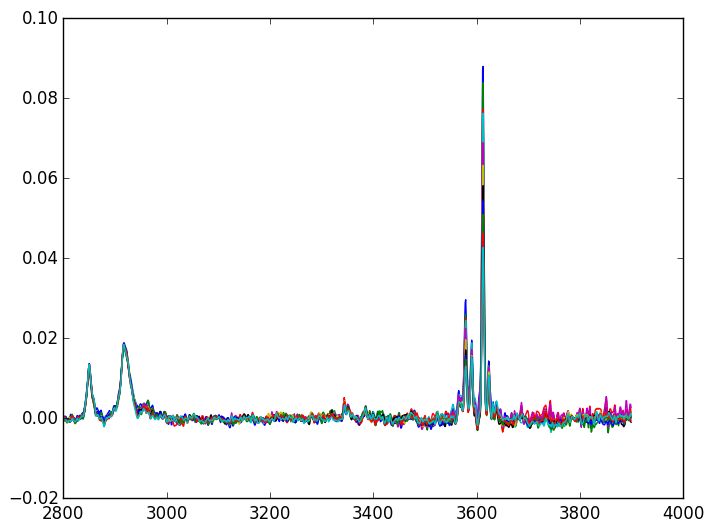

In [1]:
using PyPlot
using JuMP
using Ipopt
using Spectra
using StatsBase

# you need to modify the following three lines
data = readdlm("../Fo_exp6/Fo_exp6_P5.txt", '\t') #reading the data
parameters = readdlm("../Fo_exp6/Fo_exp6_P5_params.txt", '\t') #reading the parametersthe experience details
plot(data[find(2800 .< data[:,1] .<3900),1],data[find(2800 .< data[:,1] .<3900),25:35]) # to select the point of departure of the profil more easily

# The following lines are internal cooking stuffs to get the parameters
step = Float64(parameters[1,2]) #step is inputed in metre
time = Float64(parameters[2,2].*3600.0) #time is in seconds, convert the hours of the user input
start_sp = Int64(parameters[3,2]) #first valid spectra along profil (at the border)
stop_sp = Int64(parameters[4,2]) #last valid spectra along profil (at the centre)
low_x = Float64(parameters[5,2]) #low frequency of roi (region of interest)
high_x = Float64(parameters[6,2]) #high frequency of roi (region of interest)
first_bound_norm = Float64(parameters[7,2]) #low bond of integration for normalisation
second_bound_norm = Float64(parameters[8,2]) #high bond of integration for normalisation
first_bound_err = Float64(parameters[9,2]) #low bond of integration for error estimation
last_bound_err = Float64(parameters[10,2]) #high bond of integration for error estimation
m = Int64(parameters[11,2]) #number_peaks
# We read the array of the model parameters and suqeeze them in 1D to have vectors
c0_guess = squeeze(readdlm(IOBuffer(parameters[12,2]),','),1) #Initial concentrations
c1_guess = squeeze(readdlm(IOBuffer(parameters[13,2]),','),1) #Bondary concentrations
D_guess = squeeze(readdlm(IOBuffer(parameters[14,2]),','),1) #Diffisivity coefficients
freq_guess = squeeze(readdlm(IOBuffer(parameters[15,2]),','),1) #Frequencies of the peaks
hwhm_guess = squeeze(readdlm(IOBuffer(parameters[16,2]),','),1) #HWHM of the peaks

println("Done")

In [2]:
# We prepare the data for the fit, for that we call the function IRdataprep
x, y, y_ese_r, x_fit, y_fit, ese_fit = IRdataprep(data,step,start_sp,stop_sp,low_x,high_x,first_bound_norm,second_bound_norm, first_bound_err, last_bound_err)

# Here we apply the 10000 scaling coefficient
y = y .*10000
y_fit = y_fit .*10000
ese_fit = ese_fit .* 10000

println("Done")

Done


# Model construction
The following lines allow to build the model.

For doing so we use JuMP (https://jump.readthedocs.org/en/latest/ and https://github.com/JuliaOpt/JuMP.jl). This allows to define our problem easily, without even being tied to a particular solver.

In the following, we are going to use the Ipopt open-source solver (https://projects.coin-or.org/Ipopt). This can be changed regarding the preference of the user without affecting the model construction.

This is the strenght of JuMP: being able to write clear models and then, play with different solvers / optins without re-writing everything.

Constrains are also clearly indicated with JuMP.

In [3]:
# number of data =
n = size(x_fit)[1]

mod = Model(solver=IpoptSolver()) # we build the model with saying that we are going to use Ipopt

#Initial values, m is the number of peaks
@defVar(mod,g_c0[i=1:m] >= 0) # here we ask the concentrations to be positive while declaring them
@defVar(mod,g_c1[i=1:m] >= 0)
@defVar(mod, g_D[i=1:m] )
@defVar(mod, g_freq[i=1:m] )
@defVar(mod, g_hwhm[i=1:m] )

# setting the initial values
setValue(g_c0[i=1:m],c0_guess[i])
setValue(g_c1[i=1:m],c1_guess[i])
setValue(g_D[i=1:m],D_guess[i])
setValue(g_freq[i=1:m],freq_guess[i])
setValue(g_hwhm[i=1:m],hwhm_guess[i])

# The generic expression to build the peaks: amplitude of a gaussian peak is calculated from the diffusion of a chemical specie along a diffusion profil
@defNLExpr(mod,g_mod[j=1:n],sum{((g_c1[i] - g_c0[i]) * erfc(x_fit[j,1]/(2. * ( 10^g_D[i] * time)^0.5)) + g_c0[i]) *exp(-log(2) * (x_fit[j,2]-g_freq[i])^2/(g_hwhm[i]^2)), i=1:m})

# The objective function to solve
@setNLObjective(mod,Min,sum{(g_mod[j] - y_fit[j])^2, j=1:n})
println("Constructed...")

Constructed...


We now plot the data to see how looks like the initial model. If not good, we update the above values. Change the variable "selected_spectrum" to see the results for different spectrum.

c0 are [0.1,0.1,0.1,0.1,0.1]


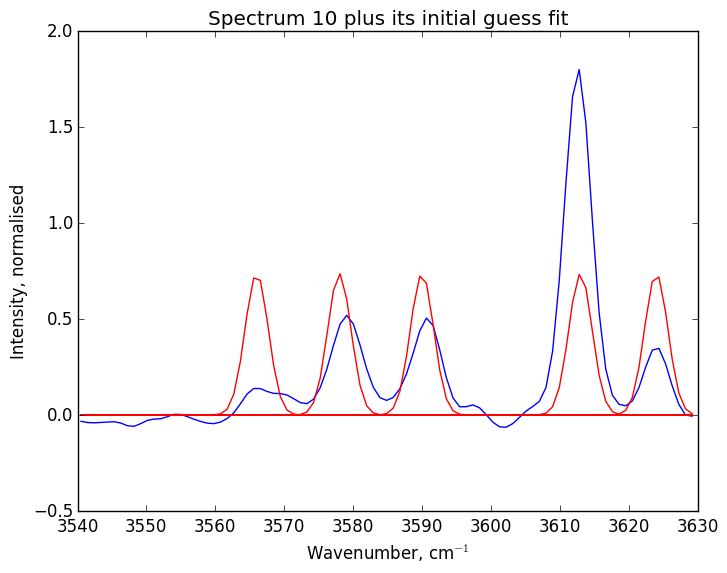

In [4]:
# parameter extractions
mod_co = getValue(g_c0)
mod_c1 = getValue(g_c1)
#mod_co = mod_co[:]*(y_max-y_min)+y_min
#mod_c1 = mod_c1[:]*(y_max-y_min)+y_min
mod_D = getValue(g_D)
mod_f = getValue(g_freq)
mod_hwhm = getValue(g_hwhm)

selected_spectrum = 10 #for peak fitting figures
model,peaks = peak_diffusion(mod_co, mod_c1, mod_D, mod_f, mod_hwhm, x_fit, time)
interest_compos = peaks[(selected_spectrum-1)*length(x)+1:(selected_spectrum-1)*length(x)+length(x),:]

fig = figure()
#plot(x, y[:,:],color="black",label="All profil")
plot(x, y[:,selected_spectrum],color="blue",label="SOI")
plot(x,interest_compos[:,:],color="red",label="Guess fit")
title("Spectrum $(selected_spectrum) plus its initial guess fit")
xlabel(L"Wavenumber, cm$^{-1}$")
ylabel("Intensity, normalised")

println("c0 are $(mod_co)")
println("c1 are $(mod_c1)")
println("D are $(mod_D)")
println("frequency are $(mod_f)")
println("hwhm are $(mod_hwhm)")

And we launch the optimisation procedure.

In [5]:
# Solve for the control and state
println("Solving...")
status = solve(mod)

# Display results
println("Solver status: ", status)
println("rmsd: ", getObjectiveValue(mod))

c1 are [1.0,1.0,1.0,1.0,1.0]
D are [-13.0,-13.0,-13.0,-13.0,-13.0]
frequency are [3566.0,3578.0,3590.0,3613.0,3624.0]
hwhm are [2.0,2.0,2.0,2.0,2.0]
Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      325

Total number of variables............................:       25
                     variables with only lower bound

We have a good solution. Let's see now how things look like (change the variable "selected_spectrum" to see the results for a different spectrum):

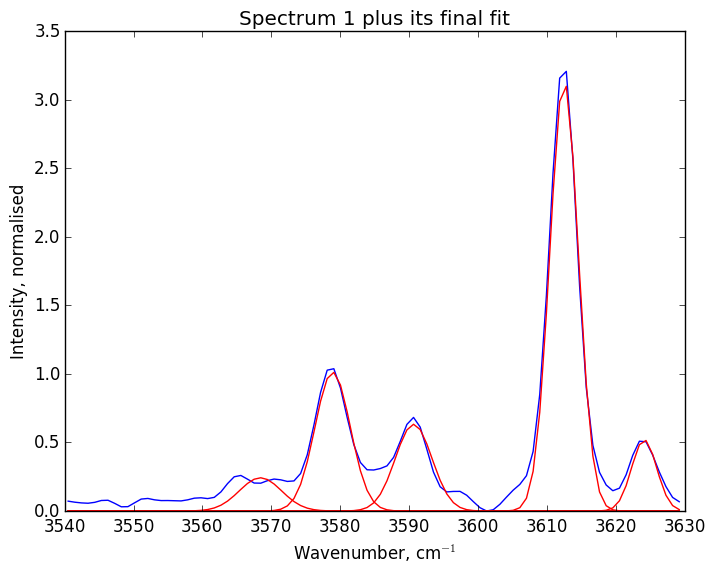

PyObject <matplotlib.text.Text object at 0x317dbd6d0>

In [6]:
# parameter extractions
mod_co_f = getValue(g_c0)
mod_c1_f = getValue(g_c1)
mod_D_f = getValue(g_D)
mod_f_f = getValue(g_freq)
mod_hwhm_f = getValue(g_hwhm)

selected_spectrum = 1 #for peak fitting figures
model,peaks = peak_diffusion(mod_co_f, mod_c1_f, mod_D_f, mod_f_f, mod_hwhm_f, x_fit, time)
interest_compos = peaks[selected_spectrum*length(x)+1:selected_spectrum*length(x)+length(x),:]

fig = figure()
#plot(x, y[:,:],color="black",label="All profil")
plot(x, y[:,selected_spectrum],color="blue",label="SOI")
plot(x,interest_compos[:,:],color="red",label="Guess fit")
title("Spectrum $(selected_spectrum) plus its final fit")
xlabel(L"Wavenumber, cm$^{-1}$")
ylabel("Intensity, normalised")

In [7]:
println("The model parameters are")
println("c0 are $(mod_co_f)")
println("c1 are $(mod_c1_f)")
println("D are $(mod_D_f)")
println("frequency are $(mod_f_f)")
println("hwhm are $(mod_hwhm_f)")


rmsd: 14.590089295490799
The model parameters are


# Error estimation
Error estimation is made with non-parametric bootstrapping: (i) we generate X new datasets; (ii) we fit those new dataset with the model and get X sets of parameters; (iii) we calculate the standard deviation of the parameters with the help of those X sets of parameters. This procedure is described in Efron and Tibshinari (1986, Statistical Science 1(1), 54-77).

In [ ]:
# test unique optimisqtion
# bootstrapping data for errors
nb_boot = 1000 # number of bootstrapping samples

params_boot = Array{Float64}(nb_boot,5,m)
vect = collect(1:size(x_fit)[1]) # for non-parametric bootstrapping

c0_guess_b = c0_guess
c1_guess_b = c1_guess
D_guess_b = D_guess
freq_guess_b = freq_guess
hwhm_guess_b = hwhm_guess

for k = 1:nb_boot
    
    # bootstrap by resampling y_fit with replacement...
    idx = sample(vect,size(vect)[1])
    b_y_f = y_fit[idx,:]
    b_x_f = x_fit[idx,:]
    
    
    modb = Model(solver=IpoptSolver(print_level=0)) # to be safe we re-define a model with no printing from Ipopt

    @defVar(modb,g_c0_b[i=1:m] >= 0) #Initial values, m is the number of peaks
    @defVar(modb,g_c1_b[i=1:m] >= 0)
    @defVar(modb, g_D_b[i=1:m] )
    @defVar(modb, g_freq_b[i=1:m] )
    @defVar(modb, g_hwhm_b[i=1:m] >= 0 )

    # setting the initial values
    setValue(g_c0_b[i=1:m],c0_guess_b[i])
    setValue(g_c1_b[i=1:m],c1_guess_b[i])
    setValue(g_D_b[i=1:m],D_guess_b[i])
    setValue(g_freq_b[i=1:m],freq_guess_b[i])
    setValue(g_hwhm_b[i=1:m],hwhm_guess_b[i])
    
    # The expression and objective functions, followed by the solving query
    @defNLExpr(modb,g_mod_b[j=1:n],sum{((g_c1_b[i] - g_c0_b[i]) * erfc(b_x_f[j,1]/(2. * ( 10^g_D_b[i] * time)^0.5)) + g_c0_b[i]) *exp(-log(2) * (b_x_f[j,2]-g_freq_b[i])^2/(g_hwhm_b[i]^2)), i=1:m})
    @setNLObjective(modb,Min,sum{(g_mod_b[j] - b_y_f[j])^2,j=1:n})
    status = solve(modb)
    println("Iteration $(k), solver status: ", status) # we print some information
    
    # we record the bootstrapped parameters
    params_boot[k,1,:] = getValue(g_c0_b)
    params_boot[k,2,:] = getValue(g_c1_b)
    params_boot[k,3,:] = getValue(g_D_b)
    params_boot[k,4,:] = getValue(g_freq_b)
    params_boot[k,5,:] = getValue(g_hwhm_b)
end
        

println("Done...")

c0 are [0.05611614105497245,0.025355638429358614,0.32337561780019153,0.0781045935228856,0.2689396811807845]
c1 are [0.25602835759696424,1.081859776209491,0.6607206730678181,3.312780262206398,0.5405911219802675]
D are [-13.622066851927913,-13.584198214190495,-13.8010504869554,-13.436727379122445,-13.716664084691317]
frequency are [3568.4154477984303,3578.8973776012076,3590.6549656131183,3612.4926162451957,3624.1147259353047]
hwhm are [3.614316722735779,3.0141171816048185,3.1409185247529035,2.4258582115845635,2.14351879066027]
Iteration 1, solver status: Optimal
Iteration 2, solver status: Optimal
Iteration 3, solver status: Optimal
Iteration 4, solver status: Optimal
Iteration 5, solver status: Optimal
Iteration 6, solver status: Optimal
Iteration 7, solver status: Optimal
Iteration 8, solver status: Optimal
Iteration 9, solver status: Optimal
Iteration 10, solver status: Optimal
Iteration 11, solver status: Optimal
Iteration 12, solver status: Optimal
Iteration 13, solver status: Optim

The following allows us to have a look at the bootstrapping results. If the bootstrapping is successful, we should see a plateau in the bootstrapping graphic. Change param_interest_boot_stat to see results for different parameters.

In [ ]:
for i = 1:m
    println("From bootstrapping, values for peak $(i):")
    println("c0 mean $(mean(params_boot[:,1,i],1)) and std $(std(params_boot[:,1,i],1))")
    println("c1 mean $(mean(params_boot[:,2,i],1)) and std $(std(params_boot[:,2,i],1))")
    println("D mean $(mean(params_boot[:,3,i],1)) and std $(std(params_boot[:,3,i],1))")
    println("frequency mean $(mean(params_boot[:,4,i],1)) and std $(std(params_boot[:,4,i],1))")
    println("hwhm mean $(mean(params_boot[:,5,i],1)) and std $(std(params_boot[:,5,i],1))")
    println("")
end

# bootstrap performance
param_interest_boot_stat = 5 # choose the parameter you want to look at

bootrecord = zeros(nb_boot,m)
for k = 1:nb_boot
    for i = 1:m
        if k == 0
            bootrecord[k,i] = 0
        else
            bootrecord[k,i] = sum(std(params_boot[1:k,param_interest_boot_stat,i],1))
        end
    end
end

fig = figure()
for i = 1:m
    plot(1:nb_boot, bootrecord[:,i],label="SOI")
end
xlabel("Number of iterations during bootstrap")
ylabel("Error")


# TODO
To be implemented soon: 
- a better way to get confidence interval from bootstrap would be to take the percentil (see... Wikipedia)
Three different approaches for generating the new datasets can be adopted:
- parametric bootstrrapping: resampling with randomly picking the new datapoints from the distribution of the existing datapoints (assumes a random distribution, with the standard error returned by the function IRdataprep; this is parametric bootstrapping);
- smooth bootstrapping: resampling with replacement AND randomly affecting each new point by an error generated from the PDF described above OR following a standard deviation equal to 1/sqrt(n) with n = length(y_fit) (smooth bootstraping).